## Testing parallel Processing of the Stochastic Paths

Running simulation...
Plotting...
Plotting finished in 3.3472 seconds.


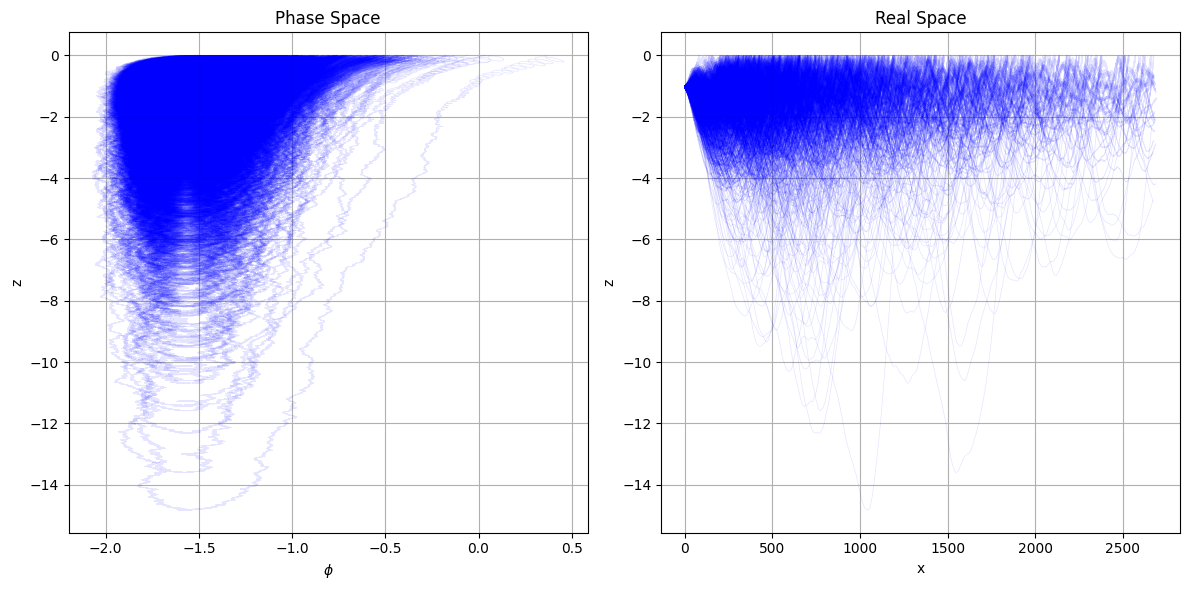

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # <--- The secret weapon
import time
from numba import njit, prange

# --- 1. Simulation Setup (Using the Numba fast method) ---
D_t = 0.0
D_r = 0.00001
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
t0 = 0.0
tn = 30000
dt = 0.1
num_paths = 1000 

t_array = np.arange(t0, tn + 1e-6, dt)
N = len(t_array)

@njit(parallel=True, fastmath=True)
def run_simulation_numba(num_paths, N, t_array, dt, D_r, lamda, alpha, sigma, beta, v0):
    all_x = np.zeros((num_paths, N), dtype=np.float64)
    all_z = np.zeros((num_paths, N), dtype=np.float64)
    all_phi = np.zeros((num_paths, N), dtype=np.float64)
    path_lengths = np.full(num_paths, N, dtype=np.int64)
    sqrt_dt_noise = np.sqrt(2 * D_r * dt)

    for p in prange(num_paths):
        curr_x, curr_z, curr_phi = 0.0, -1.0, -0.5 * np.pi
        all_x[p, 0], all_z[p, 0], all_phi[p, 0] = curr_x, curr_z, curr_phi
        
        for i in range(N - 1):
            exp_z = np.exp(curr_z)
            phase_diff = curr_x - t_array[i]
            noise = sqrt_dt_noise * np.random.standard_normal()
            
            next_phi = curr_phi + (lamda*alpha*exp_z*np.cos(phase_diff + 2*curr_phi) + 0.5*sigma*(1 + lamda*np.cos(2*curr_phi)))*dt + noise
            next_x = curr_x + (alpha*exp_z*np.cos(phase_diff) + v0*np.sin(curr_phi) + sigma *(beta + curr_z))*dt
            next_z = curr_z + (alpha*exp_z*np.sin(phase_diff) + v0*np.cos(curr_phi))*dt
            
            all_x[p, i+1], all_z[p, i+1], all_phi[p, i+1] = next_x, next_z, next_phi
            curr_x, curr_z, curr_phi = next_x, next_z, next_phi
            
            if curr_z > 0:
                path_lengths[p] = i + 2
                break
    return all_x, all_z, all_phi, path_lengths

# Run Simulation
print("Running simulation...")
raw_x, raw_z, raw_phi, lengths = run_simulation_numba(num_paths, N, t_array, dt, D_r, lamda, alpha, sigma, beta, v0)

# Process Data for plotting
# We need a list of (N, 2) arrays for LineCollection
segments_real = []
segments_phase = []

for i in range(num_paths):
    L = lengths[i]
    # Real Space Segments (x vs z)
    segments_real.append(np.column_stack((raw_x[i, :L], raw_z[i, :L])))
    
    # Phase Space processing
    phi_curr = raw_phi[i, :L]
    phip = np.mod(phi_curr, 2*np.pi)
    phipp = np.where(phip >= np.pi, phip - 2*np.pi, phip)
    
    # Note: LineCollection will draw lines connecting the jump from pi to -pi.
    # To fix this perfectly requires splitting lines, but for speed, we plot as is
    # or consider a scatter plot/2d histogram for phase space.
    segments_phase.append(np.column_stack((phipp, raw_z[i, :L])))

# --- 2. FAST Plotting with LineCollection ---
print("Plotting...")
t_plot_start = time.time()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: Phase Space ---
# Create Collection
lc_phase = LineCollection(segments_phase, linewidths=0.5, colors='blue', alpha=0.1)
ax1.add_collection(lc_phase)
ax1.autoscale() # Essential because add_collection doesn't auto-update limits
ax1.set_xlabel('$\phi$')
ax1.set_ylabel('z')
ax1.set_title('Phase Space')
ax1.grid(True)

# --- Plot 2: Real Space ---
# Create Collection
lc_real = LineCollection(segments_real, linewidths=0.5, colors='blue', alpha=0.1)
ax2.add_collection(lc_real)
ax2.autoscale()
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('Real Space')
ax2.grid(True)

plt.tight_layout()
print(f"Plotting finished in {time.time() - t_plot_start:.4f} seconds.")
plt.show()

: 